# Here we run benchmark causal discovery algorithms on the big ER graph and connectome graph.

In [1]:
# 3rd party
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#os.environ["CASTLE_BACKEND"] = "pytorch"

# castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import Notears, NotearsNonlinear

# own
import causal_helpers
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrix

#utils
from tqdm.auto import tqdm
import torch
import timeit

2024-07-11 16:27:28,130 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-07-11 16:27:28,199 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
# Set random seed
seed = 42
set_random_seed(seed)

# load the weighted adjacency matrices for ER and connectome

# Specify the folder where the adjacency matrices were saved
folder = './data/'

# Example usage to load the saved adjacency matrices
G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# Change name of the connectome adjacency matrix to C and C_dag
C = G_A_init_t_ordered_adj_matrix
C_dag = G_A_init_t_ordered_dag_adj_matrix

# Now ensure that both DAG adjacency matrices are binary, if they aren't already
ER_dag_bin = (ER_dag != 0).astype(int)
C_dag_bin = (C_dag != 0).astype(int)


2024-07-11 16:27:29,973 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/jax/_src/xla_bridge.py[line:884] - INFO: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2024-07-11 16:27:29,977 - /users-2/amine/miniconda3/envs/pcax24/lib/python3.10/site-packages/jax/_src/xla_bridge.py[line:884] - INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-07-11 16:27:30.144771: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Adjacency matrix loaded from ./data/G_A_init_t_ordered_adj_matrix.npy
Adjacency matrix loaded from ./data/G_A_init_t_ordered_dag_adj_matrix.npy
Adjacency matrix loaded from ./data/ER_adj_matrix.npy
Adjacency matrix loaded from ./data/ER_dag_adj_matrix.npy


In [ ]:
# compute average number of edges per node in ER_dag_bin
n_nodes = ER_dag_bin.shape[0]
n_edges = np.sum(ER_dag_bin)
ER_dag_bin_avg_edges_per_node = n_edges / n_nodes
print(f'Average number of edges per node in ER_dag_bin: {ER_dag_bin_avg_edges_per_node:.2f}')

# compute average number of edges per node in C_dag_bin
n_nodes = C_dag_bin.shape[0]
n_edges = np.sum(C_dag_bin)
C_dag_bin_avg_edges_per_node = n_edges / n_nodes
print(f'Average number of edges per node in C_dag_bin: {C_dag_bin_avg_edges_per_node:.2f}')

In [ ]:
# now ER and C
print("Unique values in ER:", np.unique(ER))
print()
print("Unique values in C:", np.unique(C))
print()
# show unique values in ER_dag and C_dag
print("Unique values in ER_dag:", np.unique(ER_dag))
print()
print("Unique values in C_dag:", np.unique(C_dag))
print()
# show unique values in ER_dag_bin and C_dag_bin
print("Unique values in ER_dag_bin:", np.unique(ER_dag_bin))
print()
print("Unique values in C_dag_bin:", np.unique(C_dag_bin))
print()

In [ ]:
# now print the graph name and whether it is a DAG using helper function e.g.: causal_helpers.is_dag(C))
print('ER is DAG:', causal_helpers.is_dag(ER))
print('C is DAG:', causal_helpers.is_dag(C))
print()
print('ER_dag is DAG:', causal_helpers.is_dag(ER_dag))
print('C_dag is DAG:', causal_helpers.is_dag(C_dag))
print()
print('ER_dag_bin is DAG:', causal_helpers.is_dag(ER_dag_bin))
print('C_dag_bin is DAG:', causal_helpers.is_dag(C_dag_bin))

In [ ]:
# inspect the summary statistics of the generated data and the weighted adjacency matrices
def print_summary_stats(array, name):
    print(f"Summary statistics for {name}:")
    print(f"Mean: {np.mean(array)}")
    print(f"Std Dev: {np.std(array)}")
    print(f"Min: {np.min(array)}")
    print(f"Max: {np.max(array)}")
    print(f"Shape: {array.shape}")
    print()

In [ ]:
# Function to generate and inspect matrices
def generate_and_inspect_matrices(ER_dag_bin, C_dag_bin, subset_size=None, n=5000, sem_type="gauss"):
    
    # Determine the subset size or full size
    if subset_size is not None:
        ER_dag_bin = ER_dag_bin[:subset_size, :subset_size]
        C_dag_bin = C_dag_bin[:subset_size, :subset_size]
    
    # Generate weighted adjacency matrix and observational data for ER_dag
    ER_w = simulate_parameter(ER_dag_bin)
    X_ER = simulate_linear_sem(ER_w, n, sem_type)
    
    # Generate weighted adjacency matrix and observational data for C_dag
    C_w = simulate_parameter(C_dag_bin)
    X_C = simulate_linear_sem(C_w, n, sem_type)
    
    return ER_w, X_ER, C_w, X_C


subset_size = 25  # Change this to None to use the full matrix
# ER_w and C_w are just required for the simulation of the data X_ER and X_C
ER_w, X_ER, C_w, X_C = generate_and_inspect_matrices(ER_dag_bin, C_dag_bin, subset_size)

# Example usage
print_summary_stats(ER_dag_bin, "ER_dag_bin")
print_summary_stats(ER_w, "ER_w")
print_summary_stats(X_ER, "X_ER")
print()
print_summary_stats(C_dag_bin, "C_dag_bin")
print_summary_stats(C_w, "C_w")
print_summary_stats(X_C, "X_C")

# compute average number of edges per node in subset of C_dag_bin
C_dag_bin_subset = C_dag_bin[:subset_size, :subset_size]
n_nodes_subset = C_dag_bin_subset.shape[0]
n_edges_subset = np.sum(C_dag_bin_subset)
C_dag_bin_subset_avg_edges_per_node = n_edges_subset / n_nodes_subset
print(f'Average number of edges per node in subset of C_dag_bin: {C_dag_bin_subset_avg_edges_per_node:.2f}')
      
# now create a new binary ER DAG that has: 1. C_avg_edges_per_node edges per node and 2. subset_size number of nodes
ER_dag_bin_subset = simulate_dag(d=subset_size, s0=round(C_dag_bin_subset_avg_edges_per_node*n_nodes_subset), graph_type="ER").astype(int)
ER_dag_bin_subset_w = simulate_parameter(ER_dag_bin_subset)
n=5000
sem_type="gauss"
X_ER_subset = simulate_linear_sem(ER_dag_bin_subset_w, n, sem_type)

# Print the summary statistics of the generated data and the weighted adjacency matrix for the subset
print_summary_stats(ER_dag_bin_subset, "ER_dag_bin_subset") 
print_summary_stats(ER_dag_bin_subset_w, "ER_dag_bin_subset_w")
print_summary_stats(X_ER_subset, "X_ER_subset")

# Now check if the subset is a DAG and show the unique values in the adjacency matrix
print('ER_dag_bin_subset is DAG:', causal_helpers.is_dag(ER_dag_bin_subset))
print("Unique values in ER_dag_bin_subset:", np.unique(ER_dag_bin_subset))

"""
# now do the same for the cyclic graphs C and ER
# ER
ER_cyclic_w = simulate_parameter(ER)
X_ER_cyclic = simulate_linear_sem_cyclic(ER_cyclic_w, n, sem_type)
# C
C_cyclic_w = simulate_parameter(C)
X_C_cyclic = simulate_linear_sem_cyclic(C_cyclic_w, n, sem_type)
"""

In [ ]:
print('ER_dag_bin_subset is DAG:', causal_helpers.is_dag(ER_dag_bin_subset))
print('C_dag_bin_subset is DAG:', causal_helpers.is_dag(C_dag_bin_subset))
print()
# plot the adjacency matrix of ER_dag_bin and C_dag_bin using plot_adjacency_matrix
plot_adjacency_matrix(ER_dag_bin_subset, 'ER_dag_bin_subset')
print()
plot_adjacency_matrix(C_dag_bin[:subset_size, :subset_size], 'C_dag_bin_subset')
print()

In [ ]:
def run_notears_and_evaluate(X, true_dag_bin, subset_size):
    """
    Runs Notears algorithm on the given data X, plots the estimated and true DAGs,
    and calculates the accuracy metrics.

    Args:
        X (array): The input data.
        true_dag_bin (array): The binary adjacency matrix of the true DAG.
        subset_size (int): The size of the subset for evaluation.
    
    Returns:
        dict: The accuracy metrics.
    """
    # notears learn
    nt = Notears()
    nt.learn(X)

    # plot est_dag and true_dag
    GraphDAG(nt.causal_matrix, true_dag_bin[:subset_size, :subset_size])

    # calculate accuracy
    metrics = MetricsDAG(nt.causal_matrix, true_dag_bin[:subset_size, :subset_size])
    return metrics.metrics


In [ ]:
# Run for X_C data
metrics_C = run_notears_and_evaluate(X_C, C_dag_bin, subset_size)
print(metrics_C)

In [ ]:
# Run for X_ER_subset data
metrics_ER_subset = run_notears_and_evaluate(X_ER_subset, ER_dag_bin_subset, subset_size)
print(metrics_ER_subset)

In [ ]:
# now repeat same experiment but with standardized data, where each variable is normalized to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_C_standardized = scaler.fit_transform(X_C)
X_ER_standardized = scaler.fit_transform(X_ER)
X_ER_subset_standardized = scaler.fit_transform(X_ER_subset)

In [ ]:
# Run for standardized X_C data
metrics_C_standardized = run_notears_and_evaluate(X_C_standardized, C_dag_bin, subset_size)
print(metrics_C_standardized)

In [ ]:
# Run for standardized X_ER_subset data
metrics_ER_subset_standardized = run_notears_and_evaluate(X_ER_subset_standardized, ER_dag_bin_subset, subset_size)
print(metrics_ER_subset_standardized)

In [ ]:
# notears learn
nt_lin = Notears()
nt_lin.learn(X_ER)

# plot est_dag and true_dag
#GraphDAG(nt_lin.causal_matrix, ER_dag_bin)
GraphDAG(nt_lin.causal_matrix, ER_dag_bin[:subset_size, :subset_size])

# calculate accuracy
#met_lin = MetricsDAG(nt_lin.causal_matrix, ER_dag_bin)
met_lin = MetricsDAG(nt_lin.causal_matrix, ER_dag_bin[:subset_size, :subset_size])
print(met_lin.metrics)

In [ ]:
# notears learn
nt_lin_C = Notears()
nt_lin_C.learn(X_C)

# plot est_dag and true_dag
#GraphDAG(nt_lin_C.causal_matrix, ER_dag_bin)
GraphDAG(nt_lin_C.causal_matrix, C_dag_bin[:subset_size, :subset_size])

# calculate accuracy
#met_lin = MetricsDAG(nt_lin_C.causal_matrix, ER_dag_bin)
met_lin_C = MetricsDAG(nt_lin_C.causal_matrix, C_dag_bin[:subset_size, :subset_size])
print(met_lin_C.metrics)

In [ ]:
# notears learn
nt_lin = Notears()
nt_lin.learn(X)

# plot est_dag and true_dag
GraphDAG(nt_lin.causal_matrix, true_dag)

# calculate accuracy
met_lin = MetricsDAG(nt_lin.causal_matrix, true_dag)
print(met_lin.metrics)

In [ ]:
# notears nonlinear learn (for this linear data)
nt = NotearsNonlinear(model_type='mlp', hidden_layers=(2, 1), device_type='gpu', device_ids='0, 1') # I changed the MLP model source code, now this is an MLP w/o nonlinearity and single hidden layer of size 1
# essentially, this is a linear model and should be equivalent to Notears (which is a linear model)
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(nt.causal_matrix, true_dag)
print(met.metrics)

In [ ]:
# simulate data for notears
dataset = IIDSimulation(W=C_dag, n=2000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

In [ ]:
# show unqiue values in true_dag
print("Unique values in true_dag:", np.unique(true_dag))
# print summary statistics for true_dag and X
print_summary_stats(true_dag, "true_dag")
print_summary_stats(X, "X")

In [ ]:
# simulate data for notears
dataset = IIDSimulation(W=C_dag, n=2000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

# notears learn
nt = Notears()
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(nt.causal_matrix, true_dag)
print(met.metrics)

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def adjacency_matrix_to_graph(adj_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
    return G

def inspect_graph_properties(G):
    # Number of nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    # Average degree
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    
    # Degree distribution
    degrees = [d for n, d in G.degree()]
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]
    
    # Check if the graph is a DAG
    is_dag = nx.is_directed_acyclic_graph(G)
    
    # Calculate the density of the graph
    density = nx.density(G)
    
    # Calculate the clustering coefficient
    """
    The clustering coefficient C(v) measures the local density of a node v's neighborhood by 
    comparing the actual number of edges among the neighbors of v to the maximum possible 
    number of edges (k_v*(k_v-1)) for a node with degree k_v in an undirected graph.
    In that sense C(v) is a measure of the cliquishness of the neighborhood of node v.
    For C(v) close to 0, the neighborhood of v is a sparse, disconnected set of nodes.
    For C(v) close to 1, the neighborhood of v is a clique of size k_v (i.e., a complete graph).
    """
    clustering_coefficient = nx.average_clustering(G.to_undirected())
    
    # Print properties
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Is DAG: {is_dag}")
    print(f"Density: {density:.4f}")
    print(f"Average clustering coefficient: {clustering_coefficient:.4f}")
    
    # Plot degree distributions
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.hist(degrees, bins=30, color='skyblue', edgecolor='k', alpha=0.7)
    plt.xlabel('Degree', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Degree Distribution', fontsize=16)
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.hist(in_degrees, bins=30, color='lightcoral', edgecolor='k', alpha=0.7)
    plt.xlabel('In-degree', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('In-degree Distribution', fontsize=16)
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.hist(out_degrees, bins=30, color='lightgreen', edgecolor='k', alpha=0.7)
    plt.xlabel('Out-degree', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Out-degree Distribution', fontsize=16)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Convert the adjacency matrices of ER_dag_adj_matrix and and C_dag to graphs
ER_dag_graph = adjacency_matrix_to_graph(ER_dag)
C_dag_graph = adjacency_matrix_to_graph(C_dag)

# Inspect properties of the graphs
print("Properties of ER DAG graph:")
inspect_graph_properties(ER_dag_graph)
print()
print("Properties of G_A_init_t_ordered DAG graph:")
inspect_graph_properties(C_dag_graph)

In [ ]:
# Convert the adjacency matrices of ER and G_A_init_t_ordered_adj_matrix to graphs
ER_graph = adjacency_matrix_to_graph(ER)
G_A_init_t_ordered_graph = adjacency_matrix_to_graph(G_A_init_t_ordered_adj_matrix)

# Inspect properties of the graphs
print("Properties of ER graph:")
inspect_graph_properties(ER_graph)
print()
print("Properties of G_A_init_t_ordered graph:")
inspect_graph_properties(G_A_init_t_ordered_graph)

In [ ]:
# show unique values in ER_dag and C_dag
print("Unique values in ER_dag:", np.unique(ER_dag))
print()
print("Unique values in C_dag:", np.unique(C_dag))
print()
# now ER and C
print("Unique values in ER:", np.unique(ER))
print()
print("Unique values in C:", np.unique(C))

In [ ]:
# Example usage
folder = './data/'
G_A_init_t_ordered_adj_matrix_binary = np.load(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix_binary.npy'))
G_A_init_t_ordered_dag_adj_matrix_binary = np.load(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix_binary.npy'))

# show unique values in G_A_init_t_ordered_adj_matrix_binary and G_A_init_t_ordered_dag_adj_matrix_binary
print("Unique values in G_A_init_t_ordered_adj_matrix_binary:", np.unique(G_A_init_t_ordered_adj_matrix_binary))
print()
print("Unique values in G_A_init_t_ordered_dag_adj_matrix_binary:", np.unique(G_A_init_t_ordered_dag_adj_matrix_binary))

In [ ]:
plot_adjacency_matrix(G_A_init_t_ordered_adj_matrix_binary, title="G_A_init_t_ordered Binary Adjacency Matrix")
print()
plot_adjacency_matrix(G_A_init_t_ordered_dag_adj_matrix_binary, title="G_A_init_t_ordered DAG Binary Adjacency Matrix")

In [ ]:
# now load the binary upper triangular DAG adjacency matrices for ER and connectome: ER_dag_upper_triangular_binary and G_A_init_t_ordered_dag_upper_triangular_binary
ER_dag_upper_triangular_binary = np.load(os.path.join(folder, 'ER_dag_upper_triangular_binary.npy'))
G_A_init_t_ordered_dag_upper_triangular_binary = np.load(os.path.join(folder, 'G_A_init_t_ordered_dag_upper_triangular_binary.npy'))

In [ ]:
# now plot the permuted DAG adjacency matrices of G_A_init_t_ordered_dag_upper_triangular and ER_dag_upper_triangular
plot_adjacency_matrix(G_A_init_t_ordered_dag_upper_triangular_binary, title="G_A_init_t_ordered DAG Upper Triangular Adjacency Matrix")
print()
plot_adjacency_matrix(ER_dag_upper_triangular_binary, title="ER DAG Upper Triangular Adjacency Matrix")

## Create data to debug and implement the pcax version of NOTEARS

In [3]:
# actual data
#B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4
# debugging data
B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2

# create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
#B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800
W_true = simulate_parameter(B_true)

# sample data from the linear SEM
# actual data
#X = simulate_linear_sem(W_true, n=25000, sem_type='gauss')
# for debugging
X = simulate_linear_sem(W_true, n=2500, sem_type='gauss')

# NOTE: you may not write positional arguments after keyword arguments. 
# That is, the values that you are passing positionally have to come first!

# create a dataset using the simulated data
# NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# we should expect to use that many samples actually to be able to learn the graph in a comparable way.
#dataset = IIDSimulation(W=W_true, n=25000, method='linear', sem_type='gauss')
#true_dag, X = dataset.B, dataset.X

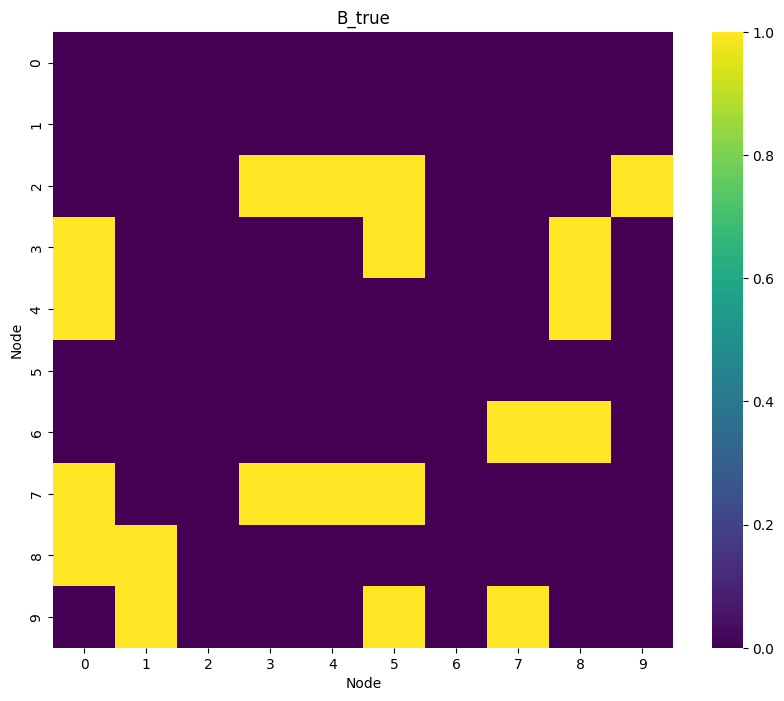


W_true:
 [[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     1.544  0.843  0.762  0.     0.     0.    -1.426]
 [ 1.948  0.     0.     0.     0.     1.551  0.     0.    -1.341  0.   ]
 [-0.656  0.     0.     0.     0.     0.     0.     0.     0.926  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     1.23   1.859  0.   ]
 [ 1.025  0.     0.     1.796  0.845  1.249  0.     0.     0.     0.   ]
 [ 1.205  0.919  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.786  0.     0.     0.    -1.111  0.     1.895  0.     0.   ]]

X has shape
: (2500, 10)


In [4]:
# plot the adjacency matrix of B_true using plot_adjacency_matrix
plot_adjacency_matrix(B_true, 'B_true')
print()
print("W_true:\n", W_true)
print()
print("X has shape\n:", X.shape)

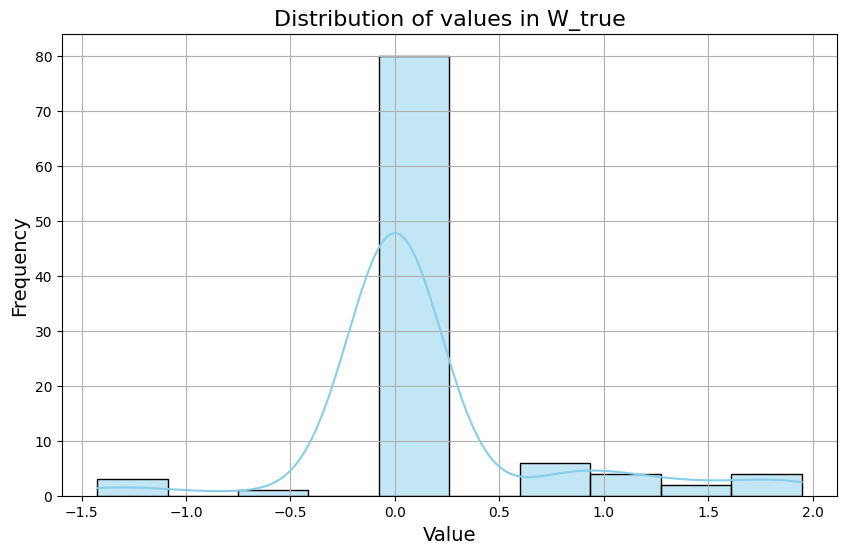

In [5]:
# plot distribution of values in W_true
plt.figure(figsize=(10, 6))
sns.histplot(W_true.flatten(), bins=10, kde=True, color='skyblue')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of values in W_true', fontsize=16)
plt.grid(True)
plt.show()

## Implement the PCAX version of NOTEARS ##

In [6]:
import jax
from jax import jit
import jax.numpy as jnp
import optax
import numpy as np

# pcax
import pcax as px
import pcax.predictive_coding as pxc
import pcax.nn as pxnn
import pcax.functional as pxf
import pcax.utils as pxu

class Complete_Graph(pxc.EnergyModule):
    def __init__(self, input_dim: int, n_nodes: int, has_bias: bool = False) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)  # Ensure input_dim is static
        self.n_nodes = px.static(n_nodes)  # Keep n_nodes as a static value
        self.has_bias = has_bias

        # vodes
        self.vodes = [pxc.Vode((input_dim,)) for _ in range(n_nodes)]

        # layers
        self.layers = []
        for i in range(n_nodes):
            for j in range(n_nodes):
                layer = pxnn.Linear(input_dim, input_dim, bias=has_bias)
                if i == j:
                    layer.nn.weight.set(jnp.zeros_like(layer.nn.weight.get()))
                self.layers.append(layer)
        
        # Create mapping to keep track of which layer connects which nodes
        self.layer_mapping = {}
        layer_idx = 0
        for i in range(n_nodes):
            for j in range(n_nodes):
                self.layer_mapping[(i, j)] = px.static(layer_idx)
                layer_idx += 1

    def freeze_nodes(self, freeze=True):
        for vode in self.vodes:
            vode.h.frozen = freeze

    def are_vodes_frozen(self):
        """Check if all vodes in the model are frozen."""
        return all(vode.h.frozen for vode in self.vodes)
    
    def get_W(self):
        """This function returns the weighted adjacency matrix based on the linear layers in the model."""
        n_nodes = self.n_nodes.get()  # Retrieve the static value
        input_dim = self.input_dim.get()  # Retrieve the static value
        W = jnp.zeros((n_nodes, n_nodes, input_dim, input_dim))
        for (i, j), layer_idx in self.layer_mapping.items():
            #W = W.at[i, j].set(self.layers[layer_idx].nn.weight.get()) # option A
            W = W.at[i, j].set(self.layers[layer_idx.get()].nn.weight.get()) # option B
        return W.squeeze()
    
    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()
        input_dim = self.input_dim.get()
        if x is not None:
            # Show the shape of x
            print("Shape of x, when x is not None, inside __call__:", x.shape)
            # show the type of x
            print("Type of x, when x is not None, inside __call__:", type(x))
            # Show type and shape of x[i]
            print("Type of x[i]:", type(jnp.atleast_1d(x[0])))
            print("Shape of x[i]:", jnp.atleast_1d(x[0]).shape)
            # Initialize nodes with given data
            for i in range(n_nodes):
                #self.vodes[i](x[i])
                self.vodes[i](jnp.atleast_1d(x[i]))

        else:
            # Perform forward pass using stored values
            x_ = jnp.array([vode.get('h') for vode in self.vodes])

            print("Shape of x_, when x is None, inside __call__:", x_.shape)

            for node_idx, vode in enumerate(self.vodes):
                node_idx_inputs = []
                for other_node_idx in range(n_nodes):
                    layer_idx = self.layer_mapping[(other_node_idx, node_idx)]

                    input_value = jnp.atleast_1d(x_[other_node_idx])

                    #input_value = x_[other_node_idx].reshape(input_dim, -1)  # v3: Ensure input_value is (input_dim, -1)
                    
                    #input_value = x_[other_node_idx] # old v1
                    #input_value = jnp.expand_dims(x_[other_node_idx], axis=-1)  # v2: Ensure correct dimensions
                    node_idx_inputs.append(self.layers[layer_idx.get()](input_value))
                    
                    # debug print the shape of input_value
                    print("Shape of input_value inside __call__:", input_value.shape)

                summed_inputs = sum(node_idx_inputs)

                # print that computing the sum of inputs was successful inside __call__ else block and show shape of summed_inputs
                print(f"Sum of inputs computed successfully inside __call__ else block. Shape of summed_inputs: {summed_inputs.shape}")
                
                #self.vodes[node_idx].set('h', summed_inputs) # gives NoneType error b/c you dont set any activation 'u' for that specific vode
                #self.vodes[node_idx].set('u', summed_inputs)
                
                self.vodes[node_idx](summed_inputs)

                # print that a single node update was successful inside __call__ else block
                print(f"Node {node_idx} updated successfully inside __call__ else block")

        # Collect the outputs and return as a JAX array using hstack
        output = jnp.hstack([vode.get('h') for vode in self.vodes])
        
        # print that the output was successfully computed inside __call__ and show the shape of the output
        print(f"Output computed successfully inside __call__. Shape of output: {output.shape}")

        return output

# Usage
input_dim = 1
n_nodes = 10
model = Complete_Graph(input_dim, n_nodes, has_bias=False)

"""
x = jnp.array([[1.0, 2.0, 3.0, 4.0, 5.0], 
               [2.0, 3.0, 4.0, 5.0, 6.0],
               [3.0, 4.0, 5.0, 6.0, 7.0],  
               [4.0, 5.0, 6.0, 7.0, 8.0]])
output = model(x)
print("This is the output of the graph: ", output) # this essentially returns the vodes data for each node after a forward pass
print("This is the type of the output: ", type(output))
print("This is the shape of the output: ", output.shape)
"""

# Get weighted adjacency matrix
W = model.get_W()
print(W)
print()
print(W.shape)

# Freezing all nodes
model.freeze_nodes(freeze=True)

# Check if all nodes are frozen
print(model.are_vodes_frozen())

# Unfreezing all nodes
model.freeze_nodes(freeze=False)

# Check if all nodes are frozen
print(model.are_vodes_frozen())

[[ 0.     0.638 -0.331 -0.134 -0.637 -0.474 -0.083  0.026  0.134  0.769]
 [ 0.544  0.    -0.298 -0.613  0.583  0.025 -0.631 -0.612  0.952  0.473]
 [-0.179 -0.684  0.     0.932  0.108 -0.439  0.405  0.628  0.259  0.089]
 [-0.033 -0.352  0.451  0.     0.28   0.215 -0.587  0.761  0.82  -0.907]
 [ 0.789  0.018  0.072 -0.725  0.     0.32  -0.786  0.597  0.595  0.632]
 [-0.962  0.9    0.779  0.979  0.242  0.     0.969 -0.407  0.142  0.612]
 [ 0.25  -0.642  0.701 -0.348  0.787  0.143  0.    -0.731 -0.668 -0.721]
 [ 0.353 -0.643 -0.152  0.783  0.602 -0.297 -0.2    0.    -0.201  0.223]
 [ 0.502  0.733 -0.821  0.002 -0.926  0.586  0.799  0.418  0.     0.185]
 [ 0.267  0.104  0.831 -0.467 -0.713  0.474  0.558 -0.035  0.567  0.   ]]

(10, 10)
True
False


In [7]:
print(model)

(Complete_Graph):
  .has_bias: False
  .vodes[0].h: VodeParam(None)
  .vodes[0].cache: Cache(params=None)
  .vodes[1].h: VodeParam(None)
  .vodes[1].cache: Cache(params=None)
  .vodes[2].h: VodeParam(None)
  .vodes[2].cache: Cache(params=None)
  .vodes[3].h: VodeParam(None)
  .vodes[3].cache: Cache(params=None)
  .vodes[4].h: VodeParam(None)
  .vodes[4].cache: Cache(params=None)
  .vodes[5].h: VodeParam(None)
  .vodes[5].cache: Cache(params=None)
  .vodes[6].h: VodeParam(None)
  .vodes[6].cache: Cache(params=None)
  .vodes[7].h: VodeParam(None)
  .vodes[7].cache: Cache(params=None)
  .vodes[8].h: VodeParam(None)
  .vodes[8].cache: Cache(params=None)
  .vodes[9].h: VodeParam(None)
  .vodes[9].cache: Cache(params=None)
  .layers[0].nn.weight: LayerParam([1,1], float32)
  .layers[1].nn.weight: LayerParam([1,1], float32)
  .layers[2].nn.weight: LayerParam([1,1], float32)
  .layers[3].nn.weight: LayerParam([1,1], float32)
  .layers[4].nn.weight: LayerParam([1,1], float32)
  .layers[5].nn.we

In [8]:
lam_h = 10.0
lam_l1 = 1e-5

In [9]:
# Training and evaluation functions
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    return model(x)

@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), out_axes=(None, 0), axis_name="batch")
def energy(*, model: Complete_Graph):
    x_ = model(None)
    
    # print that running model(None) inside energy function worked
    print("Running model(None) inside energy function worked!")

    W = model.get_W()
    d = model.n_nodes.get()

    # print that getting W and d inside energy function worked
    print("Getting W and d inside energy function worked!")
    
    # compute the PC energy term (loss)
    loss = jax.lax.pmean(model.energy(), "batch")

    # print that computing the PC energy term (loss) inside energy function worked
    print("Computing the PC energy term (loss) inside energy function worked!")

    # compute L1 regularization term of W
    l1_reg = jnp.sum(jnp.abs(W))

    # compute L2 regularization term of W
    l2_reg = jnp.sum(W**2)

    # compute the DAG regularization term of W
    h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - d # where W * W is the Hadamard product of W with itself
    
    #obj = loss + lam_h * h_reg + lam_l1 * l1_reg + lam_l2 * l2_reg
    obj = loss + lam_h * h_reg + lam_l1 * l1_reg
    
    return obj, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):

    print("Training!")  # this will come in handy later

    # print the shape of x inside train_on_batch
    print("Shape of x inside train_on_batch:", x.shape)

    # This only sets an internal flag to be "train" (instead of "eval")
    model.train()

    # freeze nodes at the start of training
    model.freeze_nodes(freeze=True)

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, model=model)

    # print that the init step has been done
    print("Init step done!")

    # Reinitialize the optimizer state between different batches
    optim_h.init(pxu.Mask(pxc.VodeParam)(model))

    # print that the optimizer state has been reinitialized
    print("Optimizer state reinitialized!")

    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, x_), g = pxf.value_and_grad(
                pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(model=model)
        optim_h.step(model, g["model"], True) 
        # NOTE:
        # True in optim_h is required to scale the gradients by the batch size (since we take pmean in the energy, we are averaging the gradients, which 
        # is correct for the weights w, but not for the states h, since each sample in the batch has its own state h which should be updated independently
        # of the other states.  So essentially using True kind of "undos" the pmean operation on the energy for the states h.
        # Each weight value is influenced by all samples in the batch, so it makes sense to average the gradients for the weights.
        # Whereas each state value is influenced by its own sample in the batch, so it should be updated independently of the other states. So to make sure
        # the magnitude of the gradient is the same, independently of the batch size (number of samples), we need to scale the gradients by the batch size.
        
    # print that T inference steps have been done
    print(f"Done with {T} inference steps!")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        _, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(model=model)
    optim_w.step(model, g["model"])

    # print that the weights have been updated
    print("Weights updated!")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        forward(None, model=model)
        e = model.energy() # this returns energy per sample in the batch
        e_batch = e.mean() # this returns the average energy per sample in the batch

    # print that the batch energy was computed successfully
    print("Batch energy computed successfully!")

    # unfreeze nodes at the end of training
    model.freeze_nodes(freeze=False)
    
    return e_batch

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    batch_energies = []
    for batch in dl:
        # print the shape of batch inside train
        print("Shape of batch inside train:", batch.shape)

        e_batch = train_on_batch(T, batch, model=model, optim_w=optim_w, optim_h=optim_h)
        batch_energies.append(e_batch)

    W = model.get_W()
    # compute epoch energy
    epoch_energy = jnp.mean(jnp.array(batch_energies))
    return W, epoch_energy

In [10]:
@jit
def MAE(W_true, W):
    """This function returns the Mean Absolute Error for the difference between the true weighted adjacency matrix W_true and th estimated one, W."""
    W_diff = jnp.mean(jnp.abs(W - W_true))
    return W_diff

In [11]:
w_learning_rate = 1e-4
h_learning_rate = 1e-4
T = 16
nm_epochs = 20
batch_size = 128

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )


# Create the custom dataset
dataset = CustomDataset(X)

# Create the dataloader
dl = TorchDataloader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jnp.zeros((batch_size, model.n_nodes.get())), model=model)
    optim_h = pxu.Optim(optax.sgd(h_learning_rate), pxu.Mask(pxc.VodeParam)(model))
    optim_w = pxu.Optim(optax.sgd(w_learning_rate, momentum=0.95), pxu.Mask(pxnn.LayerParam)(model))

# Initialize lists to store differences and energies
diffs = []
energies = []

# Calculate the initial difference
W_diff_init = MAE(W_true, model.get_W())
print(f"Start difference (cont.) between W_true and W_init: {W_diff_init}")

# Start timing
start_time = timeit.default_timer()

# Training loop
with tqdm(range(nm_epochs), position=0, leave=True) as pbar:
    for epoch in pbar:
        # Train for one epoch using the dataloader
        W, epoch_energy = train(dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        
        # Calculate the difference and store it
        W_diff = MAE(W_true, W)
        diffs.append(W_diff)
        energies.append(epoch_energy)
        
        # Update progress bar with the current status
        pbar.set_description(f"MAE {W_diff:.4f} || Energy {epoch_energy:.4f} @ Epoch {epoch + 1}")

# End timing
end_time = timeit.default_timer()

# Print the average time per epoch
average_time_per_epoch = (end_time - start_time) / nm_epochs
print(f"An epoch (with compiling and testing) took on average: {average_time_per_epoch:.4f} seconds")

Shape of x, when x is not None, inside __call__: (10,)
Type of x, when x is not None, inside __call__: <class 'jax._src.interpreters.batching.BatchTracer'>
Type of x[i]: <class 'jax._src.interpreters.batching.BatchTracer'>
Shape of x[i]: (1,)
Output computed successfully inside __call__. Shape of output: (10,)
Start difference (cont.) between W_true and W_init: 0.5910936594009399


  0%|          | 0/20 [00:00<?, ?it/s]

Shape of batch inside train: (128, 10)
Training!
Shape of x inside train_on_batch: (128, 10)
Shape of x, when x is not None, inside __call__: (10,)
Type of x, when x is not None, inside __call__: <class 'jax._src.interpreters.batching.BatchTracer'>
Type of x[i]: <class 'jax._src.interpreters.batching.BatchTracer'>
Shape of x[i]: (1,)
Output computed successfully inside __call__. Shape of output: (10,)


/users-2/amine/miniconda3/envs/pcax24/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Init step done!
Optimizer state reinitialized!
Shape of x_, when x is None, inside __call__: (10, 1)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Sum of inputs computed successfully inside __call__ else block. Shape of summed_inputs: (1,)
Node 0 updated successfully inside __call__ else block
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value inside __call__: (1,)
Shape of input_value

In [14]:
model.get_W()

Array([[ 0.135,  0.269, -0.151,  0.132,  0.038,  0.467,  0.058,  0.101,
         0.258,  0.112],
       [ 0.201,  0.091, -0.008, -0.058,  0.246, -0.345,  0.004,  0.017,
         0.406,  0.087],
       [-0.055, -0.268,  0.016,  0.168,  0.062,  0.152,  0.008, -0.081,
         0.209, -0.156],
       [ 0.562, -0.417, -0.015,  0.035,  0.142,  0.459, -0.158,  0.26 ,
        -0.259, -0.182],
       [ 0.299,  0.133,  0.008,  0.094,  0.048,  0.411, -0.126,  0.159,
         0.096,  0.109],
       [ 0.201, -0.096,  0.162,  0.22 ,  0.102,  0.125,  0.183,  0.046,
        -0.196, -0.02 ],
       [ 0.521,  0.019,  0.331,  0.003, -0.027,  0.15 ,  0.016, -0.315,
         0.251, -0.359],
       [ 0.509, -0.15 , -0.29 ,  0.142,  0.157,  0.203, -0.015,  0.028,
        -0.321,  0.212],
       [ 0.283,  0.296,  0.085, -0.192, -0.09 , -0.227,  0.171, -0.024,
         0.074, -0.247],
       [ 0.062,  0.027,  0.044,  0.127, -0.013, -0.188, -0.026,  0.225,
        -0.186,  0.018]], dtype=float32)

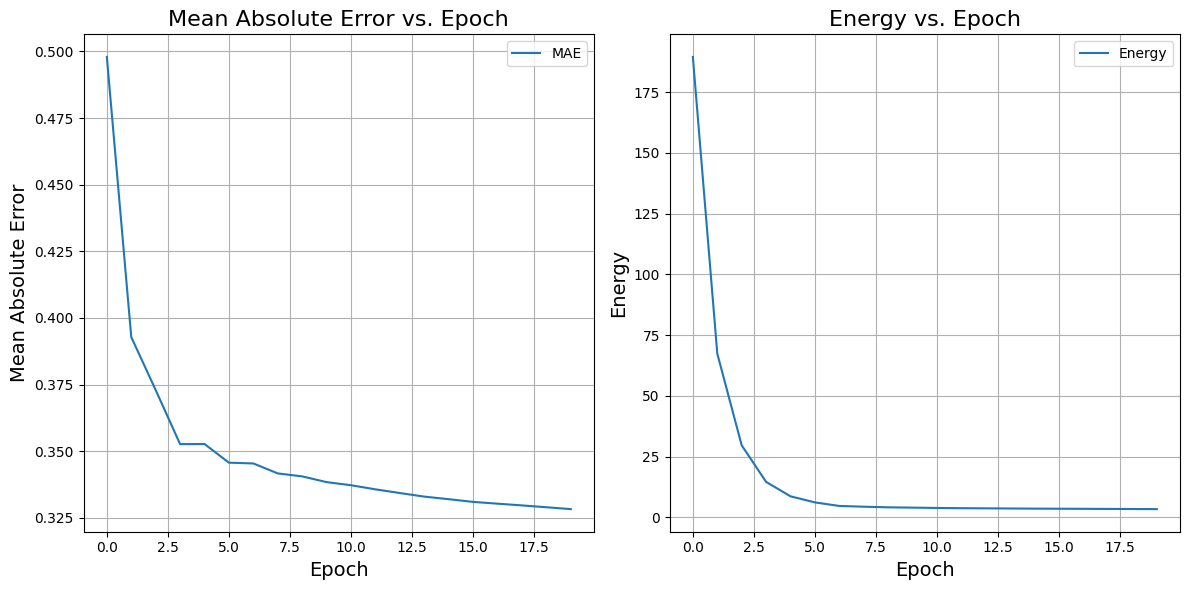

In [15]:
# now create a beautiful plot of the differences and the energies using matplotlib and seaborn 
# with energies on one axis and differences on the other axis
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(diffs, label='MAE')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Mean Absolute Error vs. Epoch', fontsize=16)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(energies, label='Energy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Energy vs. Epoch', fontsize=16)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
